# ADA Homework 2 - Data from the Web

In [1]:
# Import libraries
import requests
import json
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

## 1. 200 QS Top Universities from www.topuniversities.com 

In [80]:
NB_BEST = 200
WIKI = 'https://en.wikipedia.org/w/index.php?search='
QS_URL = "https://www.topuniversities.com"
QS_RANK_URL = "https://www.topuniversities.com/university-rankings/world-university-rankings/2018"
QS_DATA_URL = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"

In [81]:
QS_data_req = requests.get(QS_DATA_URL)
QS_data = QS_data_req.json()

In [82]:
def get_QS_number(type_string):
    wrapper = uni_soup.find("div", class_=type_string)
    if wrapper:
        string = wrapper.find("div", class_="number").text[1:]
        return int(re.sub("[^0-9^.]", "", string))
    else:
        return np.nan

In [83]:
QS_ranking = pd.DataFrame(columns = ["title", "rank_display", "country", "region"])

for i in range(NB_BEST):
    df_i = pd.DataFrame.from_dict(QS_data["data"][i], orient='index').T
    df_i = df_i.drop(["stars", "guide", "cc", "logo", "core_id", "url", "nid", "score"], axis=1)
    
    name = df_i.title[0].strip().replace(' ', '+')
    w = requests.get(WIKI + name)
    soup = BeautifulSoup(w.text, 'html.parser')
    f = soup.find("h1", {"id": "firstHeading"})
    if (f.get_text() == 'Search results'):
        ff = soup.find('div', {'class': 'mw-search-result-heading'})
        df_i['title'] = ff.get_text().strip()
    else:
        df_i['title'] = f.get_text().strip()
    
    # Get linked site with more information
    uni_url = QS_URL + QS_data["data"][i]["url"]
    uni_request = requests.get(uni_url)
    uni_page_body = uni_request.text
    uni_soup = BeautifulSoup(uni_page_body, 'html.parser')
    
    # Get total number of students
    df_i["total_students"] = get_QS_number("total student")
    # Get number of international students
    df_i["inter_students"] = get_QS_number("total inter")
    # Get number of faculty members
    df_i["faculty_members"] = get_QS_number("total faculty")
    # Get number of international faculty members
    df_i["inter_faculty_members"] = get_QS_number("inter faculty")
    
    # Store the ratio of faculty members to students
    df_i["ratio_faculty"] = df_i["faculty_members"] / df_i["total_students"]
    # Store the ratio of international students to all students
    df_i["ratio_international"] = df_i["inter_students"] / df_i["total_students"]
    QS_ranking = QS_ranking.append(df_i)
    

QS_ranking = QS_ranking.rename(columns = {'title':'name'})
QS_ranking = QS_ranking.set_index("name", drop=False)
QS_ranking = QS_ranking.add_suffix("_QS")

In [86]:
QS_ranking.head()

,country_QS,faculty_members_QS,inter_faculty_members_QS,inter_students_QS,rank_display_QS,ratio_faculty_QS,ratio_international_QS,region_QS,name_QS,total_students_QS
name,,,,,,,,,,
Massachusetts Institute of Technology,United States,2982.0,1679.0,3717.0,1,0.269450,0.335863,North America,Massachusetts Institute of Technology,11067.0
Stanford University,United States,4285.0,2042.0,3611.0,2,0.269870,0.227422,North America,Stanford University,15878.0
Harvard University,United States,4350.0,1311.0,5266.0,3,0.193945,0.234785,North America,Harvard University,22429.0
California Institute of Technology,United States,953.0,350.0,647.0,4,0.422616,0.286918,North America,California Institute of Technology,2255.0
University of Cambridge,United Kingdom,5490.0,2278.0,6699.0,5,0.292488,0.356899,Europe,University of Cambridge,18770.0


In [87]:
QS_ranking.describe()

,faculty_members_QS,inter_faculty_members_QS,inter_students_QS,ratio_faculty_QS,ratio_international_QS,total_students_QS
count,199.000000,198.000000,199.000000,199.000000,199.000000,199.000000
mean,2912.949749,786.409091,5078.261307,0.125954,0.210753,25709.130653
std,2010.741417,666.690652,3924.655224,0.060456,0.116623,17135.556845
min,86.000000,1.000000,47.000000,0.040391,0.009892,532.000000
25%,1636.500000,327.000000,2552.500000,0.084660,0.121595,15140.500000
50%,2605.000000,599.500000,4250.000000,0.115207,0.194168,23775.000000
75%,3633.500000,1027.750000,6880.500000,0.148536,0.280237,32216.000000
max,16421.000000,3905.000000,27109.000000,0.422616,0.691393,141939.000000


### 1.a) Best university in terms of ratio between faculty members and students

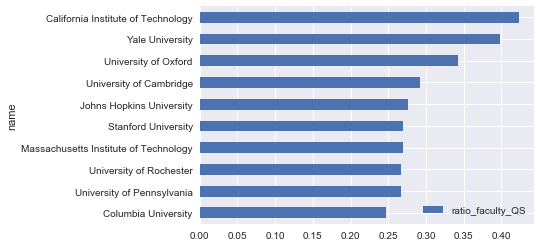

In [88]:
QS_ranking[["ratio_faculty_QS"]].sort_values("ratio_faculty_QS", ascending=False) \
    .head(10).plot.barh().invert_yaxis()

### 1.b) Best university in terms of ratio of international students to total students

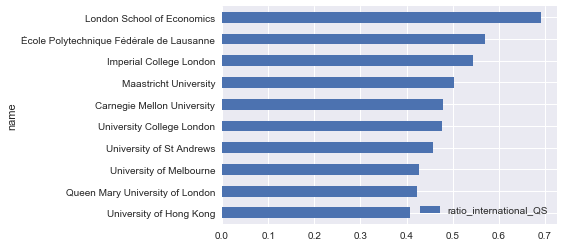

In [89]:
QS_ranking[["ratio_international_QS"]].sort_values("ratio_international_QS", ascending=False) \
    .head(10).plot.barh().invert_yaxis()

### 1.c) Best by country

#### Best university in terms of ratio between faculty members and students (by country)

In [90]:
faculty_country_df = QS_ranking.set_index(["country_QS", "name_QS"])
faculty_country_df = faculty_country_df[["ratio_faculty_QS"]]
faculty_country_df = faculty_country_df.sort_values(["ratio_faculty_QS"], ascending=False)
faculty_country_df = faculty_country_df.sort_index(level="country_QS",sort_remaining=False)
faculty_country_df.head()

ratio_faculty_QS
country_QS name_QS                                         
Argentina  University of Buenos Aires              0.134267
Australia  Australian National University          0.110788
           University of Queensland                0.084220
           University of Adelaide                  0.081403
           University of Melbourne                 0.078493

#### Best university in terms of ratio of international students to total students (by country)

In [91]:
inter_country_df = QS_ranking.set_index(["country_QS", "name_QS"])
inter_country_df = inter_country_df[["ratio_international_QS"]]
inter_country_df = inter_country_df.sort_values(["ratio_international_QS"], ascending=False)
inter_country_df = inter_country_df.sort_index(level="country_QS",sort_remaining=False)
inter_country_df.head()

ratio_international_QS
country_QS name_QS                                               
Argentina  University of Buenos Aires                    0.221658
Australia  University of Melbourne                       0.427434
           Australian National University                0.384365
           University of Adelaide                        0.382015
           University of Sydney                          0.364840

#### Barplots:

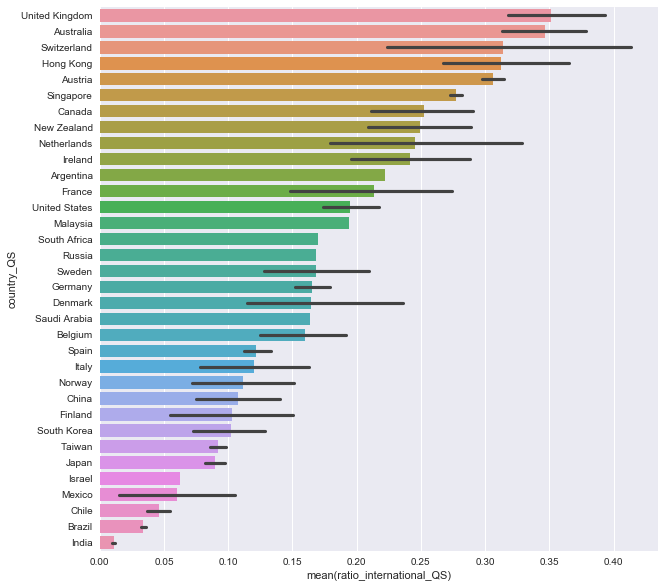

In [92]:
best_inter_country = inter_country_df.groupby("country_QS").mean().sort_values("ratio_international_QS", ascending=False)
best_inter_country = best_inter_country.rename(columns = {"ratio_international_QS": "ratio_international_QS_mean"})
best_inter_country = best_inter_country.reset_index()
best_inter_country = QS_ranking.merge(best_inter_country)
best_inter_country = best_inter_country.sort_values("ratio_international_QS_mean", ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax, y="country_QS", x="ratio_international_QS", data=best_inter_country, orient="h")

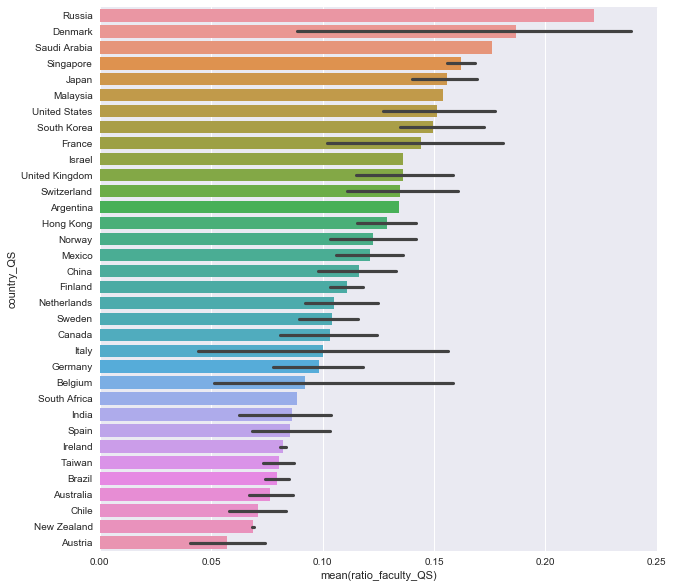

In [93]:
best_faculty_country = faculty_country_df.groupby("country_QS").mean().sort_values("ratio_faculty_QS", ascending=False)
best_faculty_country = best_faculty_country.rename(columns = {"ratio_faculty_QS": "ratio_faculty_QS_mean"})
best_faculty_country = best_faculty_country.reset_index()
best_faculty_country = QS_ranking.merge(best_faculty_country)
best_faculty_country = best_faculty_country.sort_values("ratio_faculty_QS_mean", ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax, y="country_QS", x="ratio_faculty_QS", data=best_faculty_country, orient="h")

### 1.d) Best by region

#### Best university in terms of ratio between faculty members and students (by region)

In [94]:
faculty_region_df = QS_ranking.set_index(["region_QS", "name_QS"])
faculty_region_df = faculty_region_df[["ratio_faculty_QS"]]
faculty_region_df = faculty_region_df.sort_values(["ratio_faculty_QS"], ascending=False)
faculty_region_df = faculty_region_df.sort_index(level="region_QS",sort_remaining=False)
faculty_region_df.head()

ratio_faculty_QS
region_QS name_QS                                                         
Africa    University of Cape Town                                 0.088450
Asia      Pohang University of Science and Technology             0.213025
          Tohoku University                                       0.191339
          Kyoto University                                        0.176722
          King Fahd University of Petroleum and Minerals          0.175828

#### Best university in terms of ratio of international students to total students (by region)

In [95]:
inter_region_df = QS_ranking.set_index(["region_QS", "name_QS"])
inter_region_df = inter_region_df[["ratio_international_QS"]]
inter_region_df = inter_region_df.sort_values(["ratio_international_QS"], ascending=False)
inter_region_df = inter_region_df.sort_index(level="region_QS",sort_remaining=False)
inter_region_df.head()

ratio_international_QS
region_QS name_QS                                                               
Africa    University of Cape Town                                       0.169703
Asia      University of Hong Kong                                       0.407144
          City University of Hong Kong                                  0.354221
          Nanyang Technological University                              0.281724
          Hong Kong University of Science and Technology                0.281542

#### Barplots:

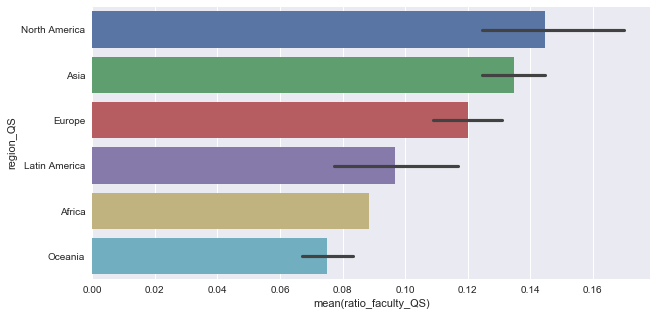

In [96]:
best_faculty_region = faculty_region_df.groupby("region_QS").mean().sort_values("ratio_faculty_QS", ascending=False)
best_faculty_region = best_faculty_region.rename(columns = {"ratio_faculty_QS": "ratio_faculty_QS_mean"})
best_faculty_region = best_faculty_region.reset_index()
best_faculty_region = QS_ranking.merge(best_faculty_region)
best_faculty_region = best_faculty_region.sort_values("ratio_faculty_QS_mean", ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(ax=ax, y="region_QS", x="ratio_faculty_QS", data=best_faculty_region, orient="h")

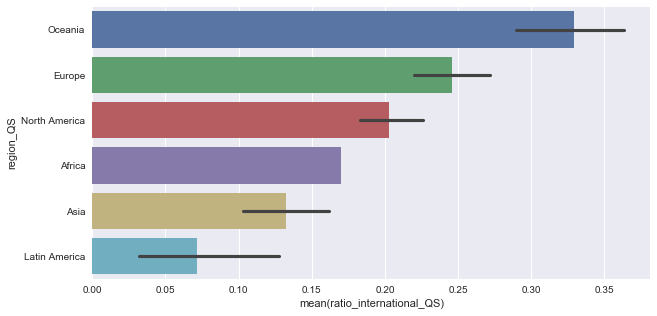

In [97]:
best_inter_region = inter_region_df.groupby("region_QS").mean().sort_values("ratio_international_QS", ascending=False)
best_inter_region = best_inter_region.rename(columns = {"ratio_international_QS": "ratio_international_QS_mean"})
best_inter_region = best_inter_region.reset_index()
best_inter_region = QS_ranking.merge(best_inter_region)
best_inter_region = best_inter_region.sort_values("ratio_international_QS_mean", ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(ax=ax, y="region_QS", x="ratio_international_QS", data=best_inter_region, orient="h")

## 2. 200 TH Top Universities from www.timeshighereducation.com

In [98]:
TH_URL = "http://timeshighereducation.com"
TH_RANK_URL = "http://timeshighereducation.com/world-university-rankings/2018/world-ranking"
TH_DATA_URL = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

In [99]:
TH_data_req = requests.get(TH_DATA_URL)
TH_data = TH_data_req.json()

In [100]:
TH_ranking = pd.DataFrame(columns = ["nid", "name", "rank", "scores_overall", "location"])

for i in range(NB_BEST):
    df_i = pd.DataFrame.from_dict(TH_data["data"][i], orient='index').T
    drop_cols = df_i.columns.difference(["nid", "name", "rank", "scores_overall", "location"])
    df_i = df_i.drop(drop_cols, axis=1)
    
    name = df_i.name[0].strip().replace(' ', '+')
    w = requests.get(WIKI + name)
    soup = BeautifulSoup(w.text, 'html.parser')
    f = soup.find("h1", {"id": "firstHeading"})
    if (f.get_text() == 'Search results'):
        ff = soup.find('div', {'class': 'mw-search-result-heading'})
        df_i['name'] = ff.get_text().strip()
    else:
        df_i['name'] = f.get_text().strip()
    
    df_i["total_students"] = int(re.sub("[^0-9^.]", "", TH_data["data"][i]["stats_number_students"]))
    percentage_intl = int(re.sub("[^0-9^.]", "", TH_data["data"][i]["stats_pc_intl_students"]))
    df_i["international_students"] = int(df_i.total_students * percentage_intl / 100)
    
    country = TH_data["data"][i]["location"]
    reg = QS_ranking.loc[QS_ranking['country_QS'] == country]['region_QS']
    if len(reg) != 0:
        region = reg.iloc[0]
    else:
        region = np.nan
    df_i["region"] = region
    
    TH_ranking = TH_ranking.append(df_i)
    
TH_ranking = TH_ranking.add_suffix("_TH")
TH_ranking = TH_ranking.rename(columns = {'name_TH':'name'})
TH_ranking = TH_ranking.set_index("name")
TH_ranking.total_students = TH_ranking.total_students_TH.astype(int)
TH_ranking.international_students = TH_ranking.international_students_TH.astype(int)

In [103]:
TH_ranking.head()

,international_students_TH,location_TH,nid_TH,rank_TH,region_TH,scores_overall_TH,total_students_TH
name,,,,,,,
University of Oxford,7755.0,United Kingdom,468,1,Europe,94.3,20409.0
University of Cambridge,6436.0,United Kingdom,470,2,Europe,93.2,18389.0
California Institute of Technology,596.0,United States,128779,=3,North America,93.0,2209.0
Stanford University,3485.0,United States,467,=3,North America,93.0,15845.0
Massachusetts Institute of Technology,3800.0,United States,471,5,North America,92.5,11177.0


In [104]:
TH_ranking.describe()

,international_students_TH,total_students_TH
count,200.000000,200.00000
mean,4964.715000,24746.29500
std,3108.431593,13353.01984
min,36.000000,515.00000
25%,2789.000000,14880.25000
50%,4437.500000,23130.50000
75%,6693.500000,32933.25000
max,16846.000000,69427.00000


## Matching

In [105]:
QS_copy = QS_ranking.copy()
TH_copy = TH_ranking.copy()

In [106]:
import difflib

In [107]:
def match_up0(x, indexes):
    matches = difflib.get_close_matches(x, indexes)
    if matches:
        return matches[0]
    else:
        return x
    
dic = []
    
def match_up1(x, indexes):
    matches = difflib.get_close_matches(x, indexes)
    for m in matches:
        if m in dic:
            return x
    
    if matches:
        dic.append(matches[0])
        return matches[0]
    else:
        dic.append(x)
        return x
    
def match_up2(x, indexes_of_b, indexes_of_a):
    matches_in_b = difflib.get_close_matches(x, indexes_of_b)
    if matches_in_b:
        matches_in_a = difflib.get_close_matches(matches_in_b[0], indexes_of_a)
        if (matches_in_a[0] == x):
            return matches_in_b[0]
    return x

#QS_copy.index = QS_copy.index.map(lambda x: match_up2(x, TH_copy.index, QS_copy.index))
merged = QS_copy.join(TH_copy, how='outer')
merged

,country_QS,faculty_members_QS,inter_faculty_members_QS,inter_students_QS,rank_display_QS,ratio_faculty_QS,ratio_international_QS,region_QS,name_QS,total_students_QS,international_students_TH,location_TH,nid_TH,rank_TH,region_TH,scores_overall_TH,total_students_TH
name,,,,,,,,,,,,,,,,,
Aalto University,Finland,1257.0,370.0,1831.0,=137,0.103482,0.150737,Europe,Aalto University,12147.0,2548.0,Finland,767,190,Europe,52.7,12744.0
Aarhus University,Denmark,2316.0,602.0,3762.0,119,0.088309,0.143445,Europe,Aarhus University,26226.0,3020.0,Denmark,589,=109,Europe,59.4,25167.0
Arizona State University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8450.0,United States,591,=126,North America,58.1,44475.0
Australian National University,Australia,1600.0,927.0,5551.0,20,0.110788,0.384365,Oceania,Australian National University,14442.0,5595.0,Australia,502,48,Oceania,71.6,15986.0
Autonomous University of Barcelona,Spain,2187.0,230.0,3848.0,=195,0.068374,0.120303,Europe,Autonomous University of Barcelona,31986.0,5169.0,Spain,666,=147,Europe,56.2,32309.0
Autonomous University of Madrid,Spain,2738.0,181.0,2976.0,187,0.103278,0.112255,Europe,Autonomous University of Madrid,26511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Boston University,United States,3157.0,379.0,7041.0,81,0.123022,0.274375,North America,Boston University,25662.0,6208.0,United States,518,=70,North America,65.4,24833.0
Brown University,United States,1303.0,379.0,1825.0,53,0.140850,0.197276,North America,Brown University,9251.0,1779.0,United States,513,=50,North America,70.8,8898.0
California Institute of Technology,United States,953.0,350.0,647.0,4,0.422616,0.286918,North America,California Institute of Technology,2255.0,596.0,United States,128779,=3,North America,93.0,2209.0


In [112]:
nans = lambda df: df[df.isnull().any(axis=1)]
nans(merged).head()

,country_QS,faculty_members_QS,inter_faculty_members_QS,inter_students_QS,rank_display_QS,ratio_faculty_QS,ratio_international_QS,region_QS,name_QS,total_students_QS,international_students_TH,location_TH,nid_TH,rank_TH,region_TH,scores_overall_TH,total_students_TH
name,,,,,,,,,,,,,,,,,
Arizona State University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8450.0,United States,591,=126,North America,58.1,44475.0
Autonomous University of Madrid,Spain,2738.0,181.0,2976.0,187,0.103278,0.112255,Europe,Autonomous University of Madrid,26511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Case Western Reserve University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1924.0,United States,557,158,North America,55.2,10130.0
CentraleSupélec,France,529.0,137.0,1132.0,177,0.136446,0.291978,Europe,CentraleSupélec,3877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chalmers University of Technology,Sweden,1077.0,336.0,1465.0,133,0.116344,0.158259,Europe,Chalmers University of Technology,9257.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
def rank_to_int(rank_obj):
    rank_str = re.sub("[^0-9^.]", "", rank_obj)
    if rank_str:
        return int(rank_str)
    else:
        return np.nan

merged['rank_QS'] = merged['rank_display_QS'].astype('str').apply(lambda x: rank_to_int(x))
merged = merged.rename(columns = {'rank_TH':'rank_display_TH'})
merged['rank_TH'] = merged['rank_display_TH'].astype('str').apply(lambda x: rank_to_int(x))

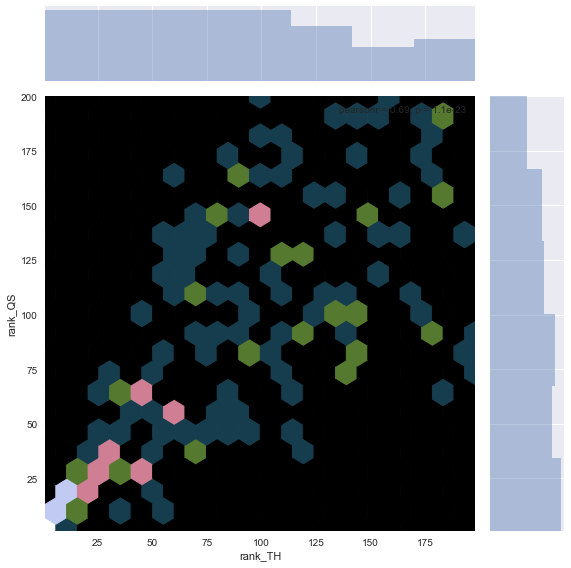

In [117]:
sns.jointplot(x='rank_TH', y='rank_QS', data=merged, kind='hex', cmap= 'cubehelix', size=8, gridsize=20)

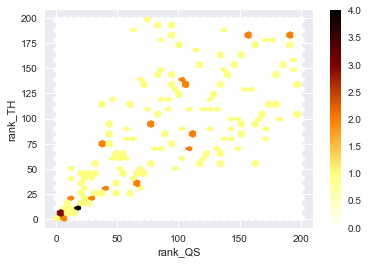

In [118]:
merged.plot(y= 'rank_TH', x ='rank_QS',kind='hexbin',gridsize=35, sharex=False, \
            colormap='afmhot_r')

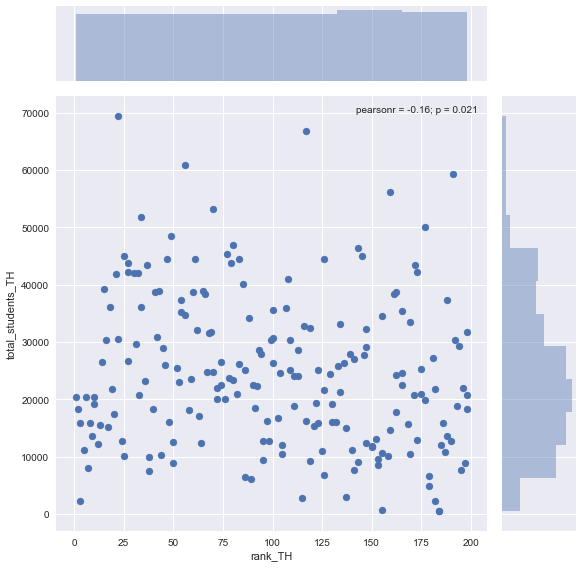

In [119]:
sns.jointplot(x='rank_TH', y='total_students_TH', data=merged, kind='scatter', cmap= 'cubehelix', size=8)

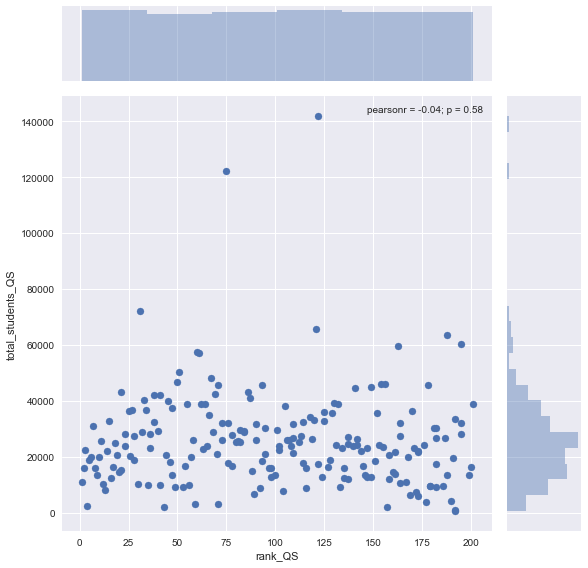

In [120]:
sns.jointplot(x='rank_QS', y='total_students_QS', data=merged, kind='scatter', cmap= 'cubehelix', size=8)

In [121]:
merged['inter_perc_QS'] = 100 * merged['inter_students_QS'] / merged['total_students_QS']
merged['inter_perc_TH'] = 100 * merged['international_students_TH'] / merged['total_students_TH']

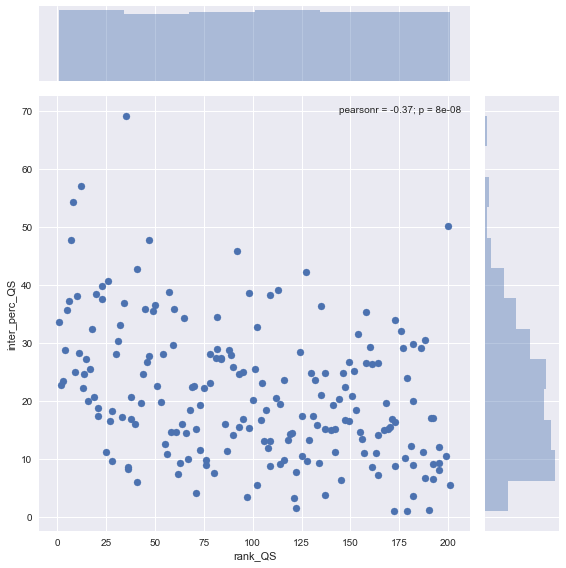

In [122]:
sns.jointplot(x='rank_QS', y='inter_perc_QS', data=merged, kind='scatter', cmap= 'cubehelix', size=8)

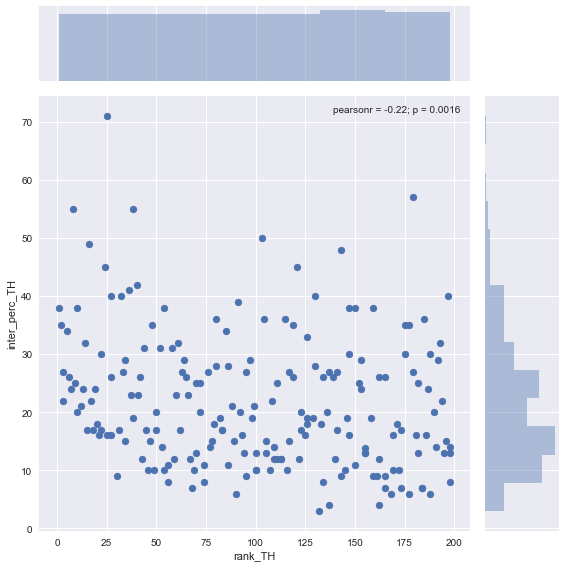

In [123]:
sns.jointplot(x='rank_TH', y='inter_perc_TH', data=merged, kind='scatter', cmap= 'cubehelix', size=8)

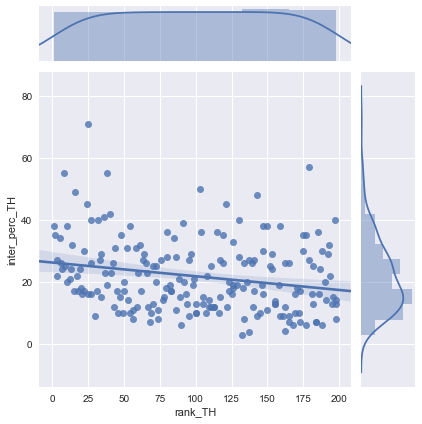

In [124]:
g = sns.JointGrid(x='rank_TH', y='inter_perc_TH', data=merged) 
g.plot_joint(sns.regplot, order=1) 
g.plot_marginals(sns.distplot)

In [127]:
merged["avg_rank"] = merged[['rank_TH', 'rank_QS']].mean(axis=1)
top = merged.sort_values("avg_rank").head()
top[["avg_rank", "rank_QS", "rank_TH"]]

,avg_rank,rank_QS,rank_TH
name,,,
Stanford University,2.5,2.0,3.0
Massachusetts Institute of Technology,3.0,1.0,5.0
University of Cambridge,3.5,5.0,2.0
California Institute of Technology,3.5,4.0,3.0
University of Oxford,3.5,6.0,1.0
